In [1]:
import h5py
import numpy as np
from espirit import espirit, espirit_proj, ifft
import matplotlib.pyplot as plt
from ipywidgets import interact


In [2]:


f = h5py.File('train/file_brain_AXFLAIR_201_6002902.h5', 'r')
list(f.keys())



['ismrmrd_header', 'kspace', 'reconstruction_rss']

In [2]:
print(f['kspace'].shape)
# slice, coil, h, w

(14, 20, 640, 320)


In [9]:

# kdata = f['kspace']
# kspace = np.transpose(kdata, (3,2,0,1)) 
# kspace.shape

(320, 640, 14, 20)

In [3]:
# Load data
orgFilename = 'file_brain_AXFLAIR_201_6002902.h5'
f = h5py.File('train/'+orgFilename, 'r')
#X = f['kspace'][:1,:,:,:]  # slice(z), coils/channels, h (y), w (x)  ###! Just loading one slice
X = f['kspace']
#X = X[len(X)-1:len(X),:,:,:]  # slice(z), coils/channels, h (y), w (x)  
slice = 5
X = X[slice:slice+1,:,:,:]  # slice(z), coils/channels, h (y), w (x)  
# Expected dimensions from E-SPIRiT are (sx, sy, sz, nc)
#X = np.transpose(X, (3,2,0,1)) # We need the following sequence : 3 , 2 , 0 , 1
X = np.transpose(X, (0,2,3,1))  # They asked like  specified in the previous line, but instead use it like this in the example...

x = ifft(X, (0,1,2))

print(X.shape)
print(x.shape)

# Derive ESPIRiT operator
esp = espirit(X, 6, 24, 0.01, 0.9925) 
# Do 
ip, proj, null = espirit_proj(x, esp)


(1, 640, 320, 20)
(1, 640, 320, 20)


In [4]:
print(esp.shape)
print(x.shape)
print(ip.shape, proj.shape, null.shape)

(1, 640, 320, 20, 20)
(1, 640, 320, 20)
(1, 640, 320, 20) (1, 640, 320, 20) (1, 640, 320, 20)


In [25]:
espgut = np.squeeze(np.transpose(esp[...,0], (0,3,1,2)))
espgut.shape

(20, 640, 320)

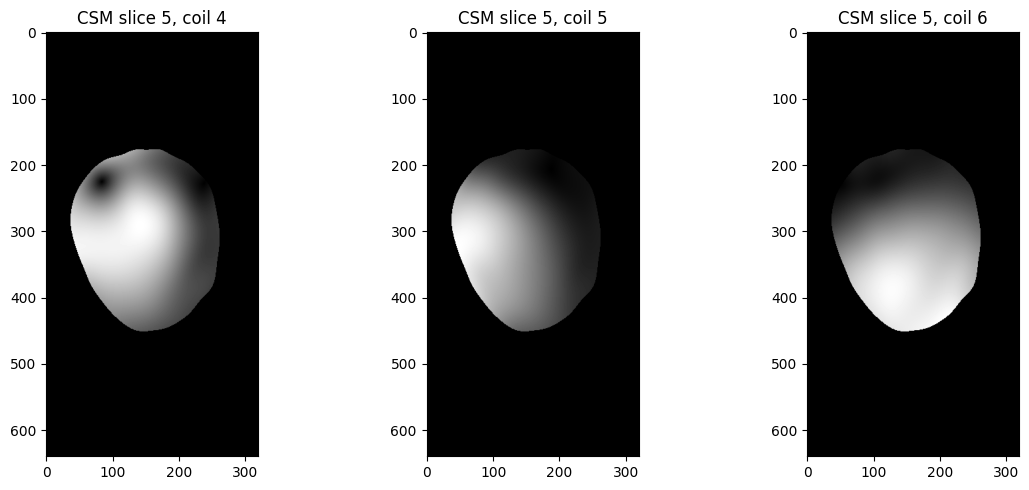

In [31]:
## ! This is from ESPIRiT
# Figure code
coil = 5

plt.figure(figsize=(12,5))
plt.subplot(1,3,1); plt.imshow(np.abs(espgut[coil-1,...]), cmap="gray"); plt.title(f'CSM slice {slice}, coil {coil-1}')
plt.subplot(1,3,2); plt.imshow(np.abs(espgut[coil,...]), cmap="gray"); plt.title(f'CSM slice {slice}, coil {coil}')
plt.subplot(1,3,3); plt.imshow(np.abs(espgut[coil+1,...]), cmap="gray"); plt.title(f'CSM slice {slice}, coil {coil+1}')
plt.tight_layout() 

In [19]:
with h5py.File('/home/hpc/iwbi/iwbi009h/CIP_-MoDL_vs_VarNet-/fastMRI/csm_file_brain_AXFLAIR_201_6002902.h5') as csmsigpy:
    csms = csmsigpy['trnCsm'][()]


17.612282


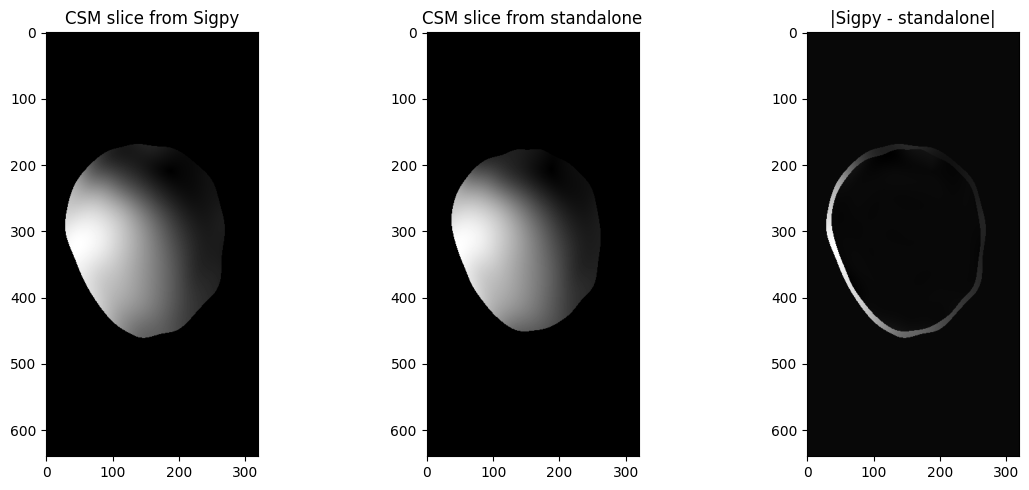

In [36]:

plt.figure(figsize=(12,5))
plt.subplot(1,3,1); plt.imshow(np.abs(csms[slice,coil,...]), cmap="gray"); plt.title(f'CSM slice from Sigpy') # slice {slice}, coil {coil}')
plt.subplot(1,3,2); plt.imshow(np.abs(espgut[coil,...]), cmap="gray"); plt.title(f'CSM slice from standalone') # {slice}, coil {coil}')
plt.subplot(1,3,3); plt.imshow((np.abs(csms[slice,coil,...])- np.abs(espgut[coil,...])), cmap="gray"); plt.title(f'|Sigpy - standalone|') # {slice}, coil {coil}')
plt.tight_layout() 
l2_norm = np.sqrt(np.sum((np.abs(espgut[coil,...])-np.abs(csms[slice,coil,...]))**2))
print(l2_norm)

In [33]:
print(np.power(np.squeeze(proj), 1/3).shape)

(1, 640, 320, 20)
(640, 320, 20)


In [12]:
from ipywidgets import interact
def plotCSMs(x, ip, proj, null):
  @interact
  def plotCSMs(i=(0,x.shape[-1]-1)):
    plt.figure(figsize=(12,5))
    plt.subplot(1,4,1); plt.imshow(np.abs(x[:,:,i]), cmap = 'gray'); plt.title(f'Data coil #{i}')
    plt.subplot(1,4,2); plt.imshow(np.abs(ip[:,:,i]), cmap = 'gray'); plt.title(f'Inner product coil  #{i}')
    plt.subplot(1,4,3); plt.imshow(np.abs(proj[:,:,i]), cmap = 'gray'); plt.title(f'Projection coil  #{i}')
    plt.subplot(1,4,4); plt.imshow(np.abs(null[:,:,i]), cmap = 'gray'); plt.title(f'Null Projection coil  #{i}')

In [13]:
x2 = np.power(np.squeeze(x), 1/3)
ip2 = np.power(np.squeeze(ip), 1/3)
proj2 = np.power(np.squeeze(proj), 1/3)
null2 = np.power(np.squeeze(null), 1/3)

plotCSMs(x2,ip2,proj2,null2)


interactive(children=(IntSlider(value=9, description='i', max=19), Output()), _dom_classes=('widget-interact',…

## Routine Varnet vs MODL

In [29]:
def extractESPIRiT(data, k:int = 4, r:int=24, t:float = 0.01, c:float = 0.9925): # sorry guys, the oiriginal code "supports" multislice images, but it actually doesn't work: indexing, etc.
    X = data['kspace']#[:1,:,:,:]  # slice(z), coils/channels, h (y), w (x)  
    # Expected dimensions from E-SPIRiT are (sx, sy, sz, nc)
    #X = np.transpose(X, (3,2,0,1)) # We need the following sequence : 3 , 2 , 0 , 1
    X = np.transpose(X, (0,2,3,1))  # They asked like  specified in the previous line, but instead use it like this in the example...
    esps = []
    for i in range(len(X)): ## yes, yes, we know it is not the best way :(
        print(f"step {i} started")
        if i < len(X)-1: esp = espirit(X[i:i+1,:,:,:], k,r,t,c) # 4, 12 does not work
        else: esp = espirit(X[-1:,:,:,:],  k,r,t,c) # last slide
        esps.append(np.squeeze(np.transpose(esp[...,0], (0,3,1,2))))
    return np.asarray(esps)

In [ ]:
def extractProj(data): # sorry guys, the oiriginal code "supports" multislice images, but it actually doesn't work: indexing, etc.
    X = data['kspace']#[:1,:,:,:]  # slice(z), coils/channels, h (y), w (x)  
    # Expected dimensions from E-SPIRiT are (sx, sy, sz, nc)
    #X = np.transpose(X, (3,2,0,1)) # We need the following sequence : 3 , 2 , 0 , 1
    X = np.transpose(X, (0,2,3,1))  # They asked like  specified in the previous line, but instead use it like this in the example...
    x_i = ifft(X, (0,1,2))
    
    x, ip, proj, null = ([], [], [], []) # creating lists that will "host" the results of ESPIRiT

    for i in range(len(X)): ## yes, yes, we know it is not the best way :(
        print(f"step {i} started")
        if i < len(X)-1:
            esp = espirit(X[i:i+1,:,:,:], 4, 20, 0.01, 0.9925)  # 4, 12 does not work
        else: esp = espirit(X[-1:,:,:,:], 4, 20, 0.01, 0.9925) # last slide
        # Do 
        ip_i, proj_i, null_i = espirit_proj(x_i, esp)

        x.append(np.power(np.squeeze(x_i), 1/3))
        ip.append(np.power(np.squeeze(ip_i), 1/3))
        proj.append(np.power(np.squeeze(proj_i), 1/3))
        null.append(np.power(np.squeeze(null_i), 1/3))

    return np.asarray(x), np.asarray(ip), np.asarray(proj), np.asarray(null)

Let's speed this up...

In [17]:
from numba import jit # no python mode has some troubles
@jit  
def ESPEEDiT(data, k:int = 4, r:int=20, t:float = 0.01, c:float = 0.9925): # sorry guys, the oiriginal code "supports" multislice images, but it actually doesn't work: indexing, etc.    
    X = data['kspace']#[:1,:,:,:]  # slice(z), coils/channels, h (y), w (x)  
    # Expected dimensions from E-SPIRiT are (sx, sy, sz, nc)
    #X = np.transpose(X, (3,2,0,1)) # We need the following sequence : 3 , 2 , 0 , 1
    X = np.transpose(X, (0,2,3,1))  # They asked like  specified in the previous line, but instead use it like this in the example...
    x, ip, proj, null = ([], [], [], []) # creating lists that will "host" the results of ESPIRiT
    for i in range(len(X)): ## yes, yes, we know it is not the best way :(
        print(f"step {i} started")
        if i < len(X)-1: esp = espirit(X[i:i+1,:,:,:], k,r,t,c)
        else: esp = espirit(X[-1:,:,:,:], k,r,t,c)  # last slide
        esps.append(np.squeeze(np.transpose(esp[...,0], (0,3,1,2))))
    return np.asarray(esps)

In [45]:
def saveCSM(csm: np.ndarray, name: str, mode = 'train'):
    with h5py.File(name, 'w') as target: # creating a new file containing the necesary data to use it with MoDL
            # order: <KeysViewHDF5 ['atb', 'csm', 'mask', 'org']>
            if mode == 'train':
                #target.create_dataset('atb', data = atb_data)    # is the aliased/noisy image # It is not necessary for Brain_data
                target.create_dataset('trnCsm', data = csm)    # saves the coil sensitivity maps
            elif mode == 'test':
                #target.create_dataset('atb', data = atb_data)    # is the aliased/noisy image # It is not necessary for Brain_data
                target.create_dataset('tstCsm', data = csm)    # saves the coil sensitivity maps

In [ ]:
orgFilename = 'file_brain_AXFLAIR_201_6002903.h5'
g = h5py.File('train/'+orgFilename, 'r')
proj_all_numba = ESPEEDiT(g, k = 4, r=24, t = 0.01, c = 0.9925)

In [ ]:
filename = 'csm_' + orgFilename
saveCSM(proj_all_numba, filename)

In [7]:
def plotProjSlices(X, proj):
  @interact
  def plotCSMs(i=(0,proj.shape[-1]-1), j = (0,proj.shape[0]-1)):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1); plt.imshow(np.abs(X[j,:,:]), cmap = 'gray'); plt.title(f'Ground Truth slice {j}')
    plt.subplot(1,2,2); plt.imshow(np.abs(proj[j,:,:,i]), cmap = 'gray'); plt.title(f'Projection coil  #{i}, slice {j}')
    

In [5]:
with h5py.File( "csm_file_brain_AXFLAIR_201_6002902.h5") as PROJ:
    proj_all_numba = PROJ['trnCsm'][()]

In [58]:
print(g['reconstruction_rss'].shape)

(16, 320, 320)


In [8]:
plotProjSlices(f['reconstruction_rss'],proj_all_numba)

interactive(children=(IntSlider(value=9, description='i', max=19), IntSlider(value=6, description='j', max=13)…

In [ ]:
TRIAL = h5py.File(filename, 'r+')
print(TRIAL['trnCsm'])
FFF = np.concatenate((TRIAL['trnCsm'], proj), axis = 0)
print(len(FFF))

In [43]:
# We are not deleting the previous file because it could mean losing our data. So we will delete each file manually
def savingCKP(csm: np.ndarray, filename:str, mode = 'train'):
    with h5py.File(filename, 'r') as FILE:
        to_save = np.concatenate((FILE['trnCsm'], csm), axis = 0)
        with h5py.File(filename) as NEWFILE:
            if mode == 'train':
                #target.create_dataset('atb', data = atb_data)    # is the aliased/noisy image # It is not necessary for Brain_data
                NEWFILE.create_dataset('trnCsm', data = to_save)    # saves the coil sensitivity maps
            elif mode == 'test':
                #target.create_dataset('atb', data = atb_data)    # is the aliased/noisy image # It is not necessary for Brain_data
                NEWFILE.create_dataset('tstCsm', data = to_save)    # saves the coil sensitivity maps

In [44]:
def save(ground_truth: np.ndarray, csm: np.ndarray, mask: np.ndarray, name: str, mode = 'train'):
    with h5py.File(name, 'w') as target: # creating a new file containing the necesary data to use it with MoDL
            # order: <KeysViewHDF5 ['atb', 'csm', 'mask', 'org']>
            if mode == 'train':
                #target.create_dataset('atb', data = atb_data)    # is the aliased/noisy image # It is not necessary for Brain_data
                target.create_dataset('trnCsm', data = csm)    # saves the coil sensitivity maps
                target.create_dataset('trnMask', data = mask)   # is the undersampling mask 
                target.create_dataset('trnOrg', data = ground_truth)#f['reconstruction_rss'])    # this is the original ground truth
            elif mode == 'test':
                #target.create_dataset('atb', data = atb_data)    # is the aliased/noisy image # It is not necessary for Brain_data
                target.create_dataset('tstCsm', data = csm)    # saves the coil sensitivity maps
                target.create_dataset('tstMask', data = mask)   # is the undersampling mask 
                target.create_dataset('tstOrg', data = ground_truth)#f['reconstruction_rss'])    # this is the original ground truth

In [52]:

def plotCSMsWSlices(x, ip, proj, null):
  @interact
  def plotCSMs(i=(0,x.shape[-1]-1), j = (0,x.shape[0]-1)):
    plt.figure(figsize=(12,5))
    plt.subplot(1,4,1); plt.imshow(np.abs(x[j,:,:,i]), cmap = 'gray'); plt.title(f'Data coil #{i}, slice {j}')
    plt.subplot(1,4,2); plt.imshow(np.abs(ip[j,:,:,i]), cmap = 'gray'); plt.title(f'Inner product coil  #{i}, slice {j}')
    plt.subplot(1,4,3); plt.imshow(np.abs(proj[j,:,:,i]), cmap = 'gray'); plt.title(f'Projection coil  #{i}, slice {j}')
    plt.subplot(1,4,4); plt.imshow(np.abs(null[j,:,:,i]), cmap = 'gray'); plt.title(f'Null Projection coil  #{i}, slice {j}')

In [ ]:
#plotCSMs(x_all, ip_all, proj_all, null_all)

NOTE: Contrast has been changed


(-0.5, 319.5, 12799.5, -0.5)

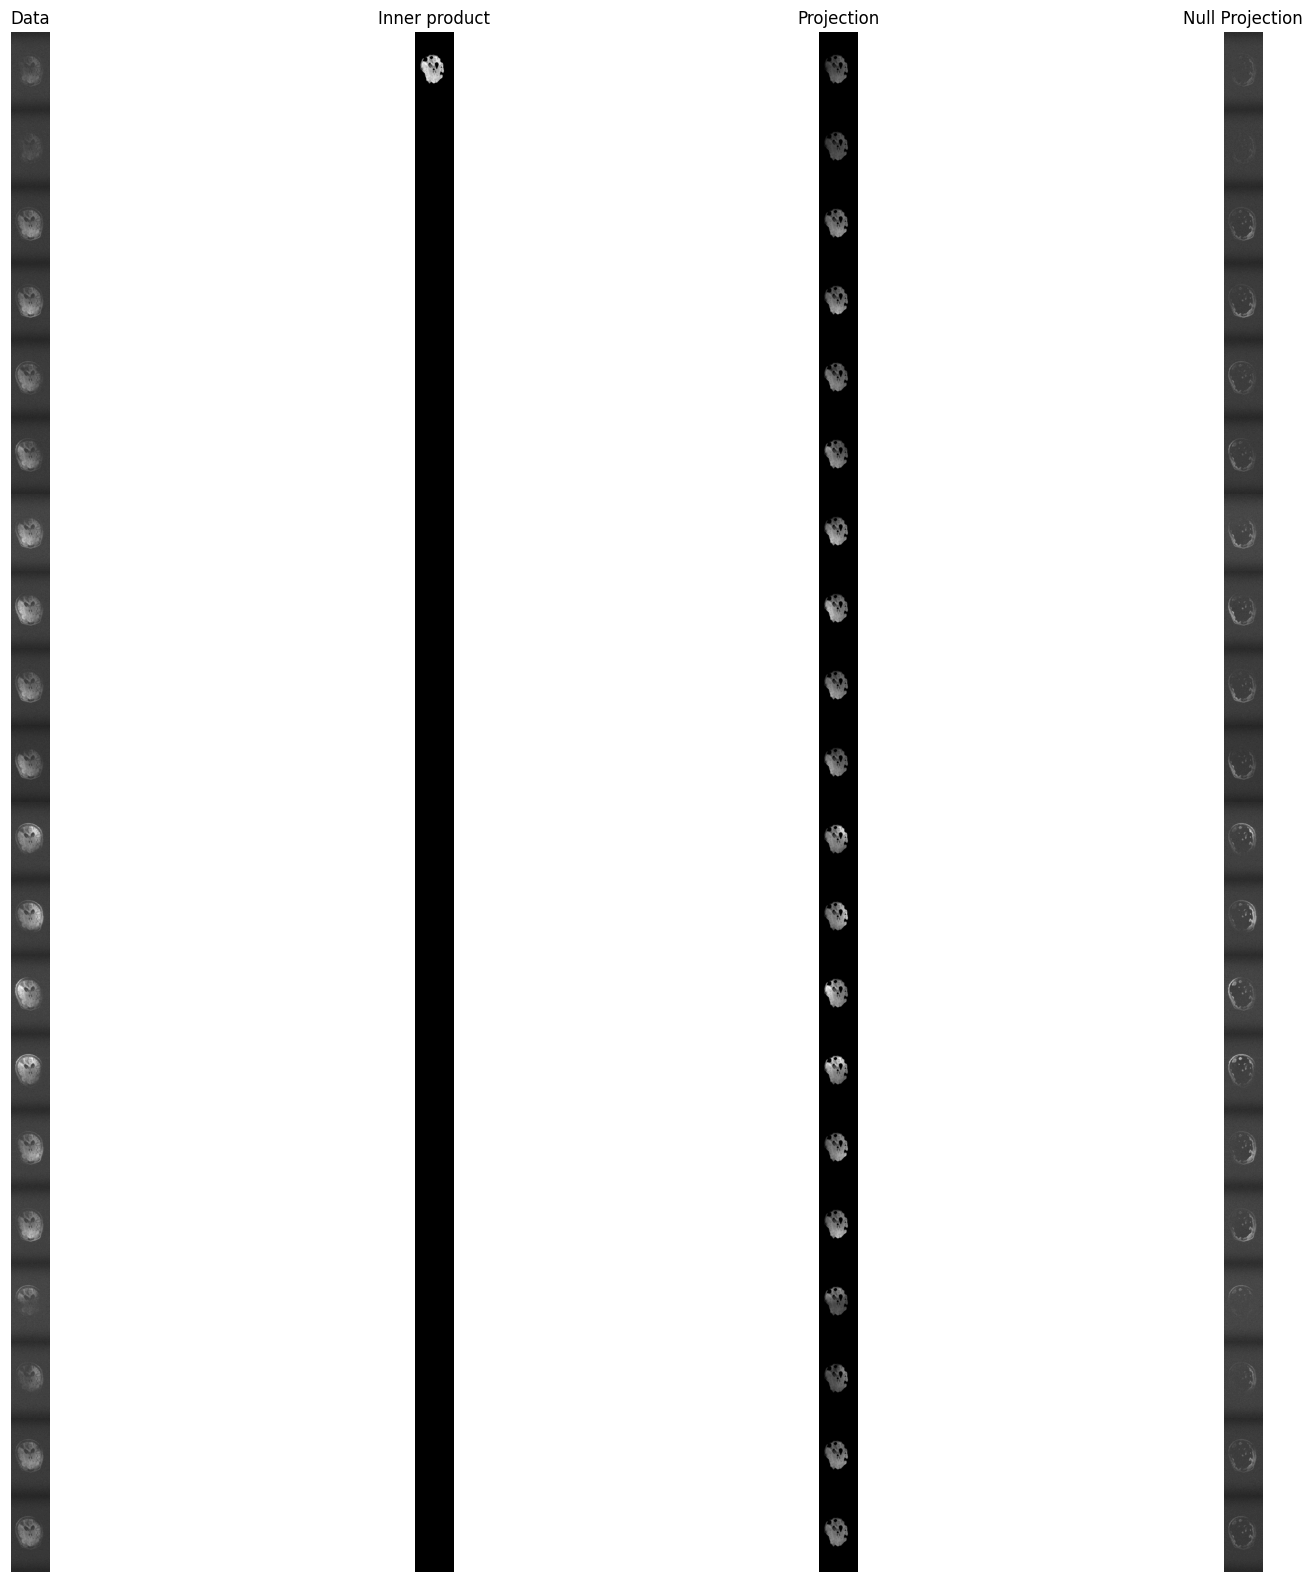

In [ ]:

dspx = np.power(np.abs(np.concatenate((x[slice,:, :, 0], x[slice,:, :, 1], x[slice,:, :, 2], x[slice,:, :, 3], x[slice,:, :, 4], x[slice,:, :, 5], x[slice,:, :, 6], x[slice,:, :, 7], x[slice,:, :, 8], x[slice,:, :, 9], x[slice,:, :, 10], x[slice,:, :, 11], x[slice,:, :, 12], x[slice,:, :, 13], x[slice,:, :, 14], x[slice,:, :, 15], x[slice,:, :, 16], x[slice,:, :, 17], x[slice,:, :, 18], x[slice,:, :, 19]), 0)), 1/3)
dspip = np.power(np.abs(np.concatenate((ip[slice,:, :, 0], ip[slice,:, :, 1], ip[slice,:, :, 2], ip[slice,:, :, 3], ip[slice,:, :, 4], ip[slice,:, :, 5], ip[slice,:, :, 6], ip[slice,:, :, 7], ip[slice,:, :, 8], ip[slice,:, :, 9], ip[slice,:, :, 10], ip[slice,:, :, 11], ip[slice,:, :, 12], ip[slice,:, :, 13], ip[slice,:, :, 14], ip[slice,:, :, 15], ip[slice,:, :, 16], ip[slice,:, :, 17], ip[slice,:, :, 18], ip[slice,:, :, 19]), 0)), 1/3)
dspproj = np.power(np.abs(np.concatenate((proj[slice,:, :, 0], proj[slice,:, :, 1], proj[slice,:, :, 2], proj[slice,:, :, 3], proj[slice,:, :, 4], proj[slice,:, :, 5], proj[slice,:, :, 6], proj[slice,:, :, 7], proj[slice,:, :, 8], proj[slice,:, :, 9], proj[slice,:, :, 10], proj[slice,:, :, 11], proj[slice,:, :, 12], proj[slice,:, :, 13], proj[slice,:, :, 14], proj[slice,:, :, 15], proj[slice,:, :, 16], proj[slice,:, :, 17], proj[slice,:, :, 18], proj[slice,:, :, 19]), 0)), 1/3)
dspnull = np.power(np.abs(np.concatenate((null[slice,:, :, 0], null[slice,:, :, 1], null[slice,:, :, 2], null[slice,:, :, 3], null[slice,:, :, 4], null[slice,:, :, 5], null[slice,:, :, 6], null[slice,:, :, 7], null[slice,:, :, 8], null[slice,:, :, 9], null[slice,:, :, 10], null[slice,:, :, 11], null[slice,:, :, 12], null[slice,:, :, 13], null[slice,:, :, 14], null[slice,:, :, 15], null[slice,:, :, 16], null[slice,:, :, 17], null[slice,:, :, 18], null[slice,:, :, 19]), 0)), 1/3)

print("NOTE: Contrast has been changed")

# Display ESPIRiT projection results 
plt.figure(figsize=(20,20))
plt.subplot(1, 4, 1)
plt.imshow(dspx, cmap='gray')
plt.title('Data')
plt.axis('off')
plt.subplot(1, 4, 2)
plt.imshow(dspip, cmap='gray')
plt.title('Inner product')
plt.axis('off')
plt.subplot(1, 4, 3)
plt.imshow(dspproj, cmap='gray')
plt.title('Projection')
plt.axis('off')
plt.subplot(1, 4, 4)
plt.imshow(dspnull, cmap='gray')
plt.title('Null Projection')
plt.axis('off')

In [ ]:
# # Figure code
# esp  = np.squeeze(esp)
# print(esp.shape)
# x    = np.squeeze(x)
# ip   = np.squeeze(ip)
# proj = np.squeeze(proj)
# null = np.squeeze(null)

# print("Close figures to continue execution...")

# # Display ESPIRiT operator
# for idx in range(8):
#     for jdx in range(8):
#         plt.subplot(8, 8, (idx * 8 + jdx) + 1)
#         plt.imshow(np.abs(esp[:,:,idx,jdx]), cmap='gray')
#         plt.axis('off')
# plt.show()

# dspx = np.power(np.abs(np.concatenate((x[:, :, 0], x[:, :, 1], x[:, :, 2], x[:, :, 3], x[:, :, 4], x[:, :, 5], x[:, :, 6], x[:, :, 7]), 0)), 1/3)
# dspip = np.power(np.abs(np.concatenate((ip[:, :, 0], ip[:, :, 1], ip[:, :, 2], ip[:, :, 3], ip[:, :, 4], ip[:, :, 5], ip[:, :, 6], ip[:, :, 7]), 0)), 1/3)
# dspproj = np.power(np.abs(np.concatenate((proj[:, :, 0], proj[:, :, 1], proj[:, :, 2], proj[:, :, 3], proj[:, :, 4], proj[:, :, 5], proj[:, :, 6], proj[:, :, 7]), 0)), 1/3)
# dspnull = np.power(np.abs(np.concatenate((null[:, :, 0], null[:, :, 1], null[:, :, 2], null[:, :, 3], null[:, :, 4], null[:, :, 5], null[:, :, 6], null[:, :, 7]), 0)), 1/3)

# print("NOTE: Contrast has been changed")

# # Display ESPIRiT projection results 
# plt.subplot(1, 4, 1)
# plt.imshow(dspx, cmap='gray')
# plt.title('Data')
# plt.axis('off')
# plt.subplot(1, 4, 2)
# plt.imshow(dspip, cmap='gray')
# plt.title('Inner product')
# plt.axis('off')
# plt.subplot(1, 4, 3)
# plt.imshow(dspproj, cmap='gray')
# plt.title('Projection')
# plt.axis('off')
# plt.subplot(1, 4, 4)
# plt.imshow(dspnull, cmap='gray')
# plt.title('Null Projection')
# plt.axis('off')
# plt.show()